# Экспериментальная часть

In [26]:
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
import string
from scipy.spatial.distance import jensenshannon
import scipy.io as sio
from scipy.special import rel_entr, kl_div
from scipy.stats import entropy, ks_2samp
from scipy.spatial.distance import jensenshannon
# from skmultiflow.drift_detection import DDM, PageHinkley, ADWIN
# from skmultiflow.data import ConceptDriftStream
import datetime
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [2]:
count_vect = CountVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
tfidf_vect = TfidfVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
porter_stemmer = nltk.stem.PorterStemmer()
tok = count_vect.build_tokenizer()
clf = LogisticRegression(solver='liblinear', C = 2.8, penalty = 'l1')
samples_number = 7

In [3]:
df_all = pd.read_csv('Electronics_5.csv')
# df_all.reviewTime = pd.to_datetime(df_all.reviewTime, format="%Y-%m-%d")
# df_all = df_all.sort_values(by = 'reviewTime').reset_index(drop = True)
df_all

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"
...,...,...,...,...,...,...,...,...,...
1689183,A34BZM6S9L7QI4,B00LGQ6HL8,"Candy Cane ""Is it just me?""","[1, 1]",Burned these in before listening to them for a...,5,Boom -- Pop -- Pow. These deliver.,1405555200,"07 17, 2014"
1689184,A1G650TTTHEAL5,B00LGQ6HL8,"Charles Spanky ""Zumina Reviews""","[0, 0]",Some people like DJ style headphones or earbud...,5,"Thin and light, without compromising on sound ...",1405382400,"07 15, 2014"
1689185,A25C2M3QF9G7OQ,B00LGQ6HL8,Comdet,"[0, 0]",I&#8217;m a big fan of the Brainwavz S1 (actua...,5,Same form factor and durability as the S1 with...,1405555200,"07 17, 2014"
1689186,A1E1LEVQ9VQNK,B00LGQ6HL8,J. Chambers,"[0, 0]","I've used theBrainwavz S1 In Ear Headphones, a...",5,Superb audio quality in a very comfortable set...,1405641600,"07 18, 2014"


In [4]:
df_all.reviewTime = pd.to_datetime(df_all.reviewTime, format="%m %d, %Y")
df_all = df_all.sort_values(by = 'reviewTime').reset_index(drop = True)
df_all["bin_label"] = df_all.overall > 3
df_all["label"] = df_all.overall.apply(lambda x: '3' if x == 3 else ('1-2' if x < 3 else '4-5'))
df_all["words"] = list(map(lambda elem: (" ").join(map(lambda s: (porter_stemmer.stem(s)), elem)).lower().translate(str.maketrans('', '', string.punctuation)), map(lambda wrds: tok(wrds), df_all.reviewText.apply(lambda x: np.str_(x)))))
df_all

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,bin_label,label,words
0,A1ABVP0DV1ZN89,B00000JBAT,Adam Sacks,"[0, 0]",The RIO rocks! It is so great that Diamond Mul...,5,WOW! THE BEST THING TO HAPPEN TO MUSIC!,929232000,1999-06-13,True,4-5,the rio rock it is so great that diamond multi...
1,A6ILK3FXYH595,B00000J4FS,kc2kth,"[1, 1]",I have found a few places that will do memory ...,5,After-market Memory Upgrades,931132800,1999-07-05,True,4-5,have found few place that will do memori upgra...
2,A7RV1KU5O0II9,B00000JFMK,"David S. Saunders ""Equal parts tech geek, bra...","[0, 0]",I love this player! I travel frequently and th...,5,Incredible screen!,931392000,1999-07-08,True,4-5,love thi player travel frequent and the l50 ke...
3,AJ6TMOHHFJJAJ,B00000JMO4,Ali Navaie,"[5, 5]",If you are looking for the best camcorder in t...,5,Simply the best in the market --- Get it while...,932688000,1999-07-23,True,4-5,if you are look for the best camcord in the ma...
4,A1JTSRG8SU4VFO,B00000JFE3,L. Goff,"[0, 0]",The &quot;lip-synch&quot; problem has shown up...,5,Own the Sony 550D model,932688000,1999-07-23,True,4-5,the quot lip synch quot problem ha shown up on...
...,...,...,...,...,...,...,...,...,...,...,...,...
1689183,A9DH6MLZBGUMO,B00J8ZJCUW,Jules,"[0, 0]",I had to order two of these - The GLAZZ was so...,5,10 stars! The PERFECT protection for your iPad...,1406073600,2014-07-23,True,4-5,had to order two of these the glazz wa so well...
1689184,A1SLHNA3FV9U9E,B00HZVPD72,ashtangakasha,"[0, 0]","Tiny, simple, excellent sound quality, easy to...",4,"Tiny, simple, and effective.",1406073600,2014-07-23,True,4-5,tini simpl excel sound qualiti easi to set up ...
1689185,A2YQ9AX4GOTA0S,B00BOEG08M,NaN,"[0, 0]",Works great. Very convenient.,5,Five Stars,1406073600,2014-07-23,True,4-5,work great veri conveni
1689186,A2MUTLXDSV3JRC,B00IERCFFO,"MBW66 ""Pilcopata Man""","[0, 0]",Elegant trim case for iPad Air. No zipper case...,5,Slim case for iPad Air,1406073600,2014-07-23,True,4-5,eleg trim case for ipad air no zipper case for...


In [5]:
df_by_years = {}
for year in df_all.reviewTime.dt.year.unique().tolist():
    df_by_years[year] = df_all[df_all.reviewTime.dt.year == year].reset_index(drop = True)
    print(year, len(df_by_years[year]))
    print(df_by_years[year].bin_label.value_counts(), '\n')

1999 72
True     61
False    11
Name: bin_label, dtype: int64 

2000 817
True     686
False    131
Name: bin_label, dtype: int64 

2001 1609
True     1292
False     317
Name: bin_label, dtype: int64 

2002 2315
True     1802
False     513
Name: bin_label, dtype: int64 

2003 3547
True     2663
False     884
Name: bin_label, dtype: int64 

2004 5159
True     3655
False    1504
Name: bin_label, dtype: int64 

2005 9638
True     6994
False    2644
Name: bin_label, dtype: int64 

2006 15447
True     11528
False     3919
Name: bin_label, dtype: int64 

2007 35976
True     28404
False     7572
Name: bin_label, dtype: int64 

2008 49872
True     39460
False    10412
Name: bin_label, dtype: int64 

2009 70666
True     55304
False    15362
Name: bin_label, dtype: int64 

2010 103797
True     80475
False    23322
Name: bin_label, dtype: int64 

2011 173395
True     134860
False     38535
Name: bin_label, dtype: int64 

2012 282942
True     224559
False     58383
Name: bin_label, dtype: int64 

2

In [6]:
skf = StratifiedKFold(n_splits=samples_number)
data_by_year_splitted = {}
for year in range(2007, 2015):
    data_tmp = df_by_years[year].sample(35000)
    data_list, labels_list = [], []
    
    for train_index, test_index in skf.split(data_tmp.words, data_tmp.label):
        data = data_tmp.iloc[test_index]
        data_list.append(data.words)
        labels_list.append(data.label)
        
    data_by_year_splitted[year] = {'data': data_list, 'labels': labels_list}
    print(year)

2007
2008
2009
2010
2011
2012
2013
2014


In [28]:
df_accuracy = pd.DataFrame(np.zeros([2015-2007, (2015-2007)*samples_number]), index=range(2007, 2015), columns=pd.MultiIndex.from_product([range(2007, 2015), range(samples_number)]))
df_tvd = df_accuracy.copy()
df_js = df_accuracy.copy()
df_ks = df_accuracy.copy()
df_perc_no_zero = df_accuracy.copy()
df_f1_macro = df_accuracy.copy()
df_f1_micro = df_accuracy.copy()
df_f1_weighted = df_accuracy.copy()
df_f1 = df_accuracy.copy()
df_accuracy

2007                               2008            ... 2013            \
        0    1    2    3    4    5    6    0    1    2  ...    4    5    6   
2007  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2009  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2011  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

     2014                                
        0    1    2    3    4    5    6  
2007  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2009  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2011  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[8 rows x 56 columns]

In [32]:
for year_train in range(2007, 2015):
    for test_index in range(samples_number):
        vecotrizer = TfidfVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
        clf = LogisticRegression(solver='liblinear', C = 2.8, penalty = 'l1', class_weight='balanced')
        train_data = pd.Series(dtype=pd.StringDtype())
        train_labels = pd.Series(dtype=int)
        for train_index in range(samples_number):
            if test_index != train_index:
                train_data = train_data.append(data_by_year_splitted[year_train]['data'][train_index])
                train_labels = train_labels.append(data_by_year_splitted[year_train]['labels'][train_index])
        train_data = vecotrizer.fit_transform(train_data)
        clf.fit(train_data, train_labels)
        for year_test in range(year_train, 2015):
            test_data = vecotrizer.transform(data_by_year_splitted[year_test]['data'][test_index])
            test_labels = data_by_year_splitted[year_test]['labels'][test_index]
            df_accuracy.loc[year_train][year_test][test_index] = accuracy_score(clf.predict(test_data),test_labels)
            df_f1_macro.loc[year_train][year_test][test_index] = f1_score(clf.predict(test_data),test_labels, average='macro')
            df_f1_micro.loc[year_train][year_test][test_index] = f1_score(clf.predict(test_data),test_labels, average='micro')
            df_f1_weighted.loc[year_train][year_test][test_index] = f1_score(clf.predict(test_data),test_labels, average='weighted')
            
            dist_train = np.array(train_data.mean(axis=0))[0]
            dist_test = np.array(test_data.mean(axis=0))[0]
            tvd = sum(abs(dist_train - dist_test))/2
            js = jensenshannon(dist_train, dist_test)
            ks = ks_2samp(dist_train, dist_test).statistic
            perc_no_zero = np.count_nonzero(dist_test)/np.count_nonzero(dist_train)
            df_tvd.loc[year_train][year_test][test_index] = tvd
            df_js.loc[year_train][year_test][test_index] = js
            df_ks.loc[year_train][year_test][test_index] = ks
            df_perc_no_zero.loc[year_train][year_test][test_index] = perc_no_zero
            print("Train in {0}, test in {1}, test sample {2}\naccuracy_score = {3}, TVD = {4}, JS = {5}, KS = {6}, F1 = {7}".format(year_train, year_test, test_index, df_accuracy.loc[year_train][year_test][test_index], tvd, js, ks, df_f1_weighted.loc[year_train][year_test][test_index]))
            
# df_accuracy = df_accuracy/samples_number
# df_accuracy[df_accuracy.eq(0)] = np.nan

Train in 2007, test in 2007, test sample 0
accuracy_score = 0.8382, TVD = 1.532403671413952, JS = 0.162945197172239, KS = 0.223699070454348, F1 = 0.8419604106915746
Train in 2007, test in 2008, test sample 0
accuracy_score = 0.8414, TVD = 1.634403918724696, JS = 0.16500637406130883, KS = 0.22337329510902615, F1 = 0.8466736036121909
Train in 2007, test in 2009, test sample 0
accuracy_score = 0.834, TVD = 1.7707345763693518, JS = 0.1675734234442806, KS = 0.21456650160715834, F1 = 0.8403608449927027
Train in 2007, test in 2010, test sample 0
accuracy_score = 0.8328, TVD = 1.92446496409599, JS = 0.18391941551003518, KS = 0.2403787681348276, F1 = 0.8417585490368269
Train in 2007, test in 2011, test sample 0
accuracy_score = 0.8386, TVD = 2.070978012105539, JS = 0.20159301320109071, KS = 0.26764616453826773, F1 = 0.8479284977105657
Train in 2007, test in 2012, test sample 0
accuracy_score = 0.8462, TVD = 2.2728663486662835, JS = 0.2242713058098887, KS = 0.31186473807662235, F1 = 0.8545379192

### 3 метки

In [37]:
df_accuracy_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_accuracy_mean.loc[year_train][year_test] = df_accuracy.loc[year_train][year_test].mean()

df_accuracy_mean[df_accuracy_mean.eq(0)] = np.nan
ur_style = (df_accuracy_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.2%}", na_rep=""))
ur_style

,2007,2008,2009,2010,2011,2012,2013,2014
2007,83.92%,84.15%,83.81%,83.08%,83.34%,84.09%,85.27%,85.05%
2008,,84.10%,83.80%,82.84%,83.28%,84.40%,85.26%,85.07%
2009,,,83.94%,82.93%,83.35%,84.30%,85.27%,85.29%
2010,,,,82.93%,83.19%,84.43%,85.17%,85.55%
2011,,,,,83.12%,84.26%,85.57%,85.55%
2012,,,,,,84.27%,85.41%,85.33%
2013,,,,,,,85.03%,85.20%
2014,,,,,,,,85.25%


In [38]:
df_f1_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_f1_mean.loc[year_train][year_test] = df_f1_macro.loc[year_train][year_test].mean()

df_f1_mean[df_f1_mean.eq(0)] = np.nan
ur_style = (df_accuracy_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.2%}", na_rep=""))
ur_style

,2007,2008,2009,2010,2011,2012,2013,2014
2007,83.92%,84.15%,83.81%,83.08%,83.34%,84.09%,85.27%,85.05%
2008,,84.10%,83.80%,82.84%,83.28%,84.40%,85.26%,85.07%
2009,,,83.94%,82.93%,83.35%,84.30%,85.27%,85.29%
2010,,,,82.93%,83.19%,84.43%,85.17%,85.55%
2011,,,,,83.12%,84.26%,85.57%,85.55%
2012,,,,,,84.27%,85.41%,85.33%
2013,,,,,,,85.03%,85.20%
2014,,,,,,,,85.25%


In [39]:
df_tvd_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_tvd_mean.loc[year_train][year_test] = df_tvd.loc[year_train][year_test].mean()

df_tvd_mean[df_tvd_mean.eq(0)] = np.nan
ur_style = (df_tvd_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.3}", na_rep=""))
ur_style

,2007,2008,2009,2010,2011,2012,2013,2014
2007,1.54,1.63,1.77,1.91,2.07,2.27,2.58,2.68
2008,,1.59,1.68,1.81,1.99,2.25,2.62,2.74
2009,,,1.62,1.72,1.92,2.22,2.64,2.77
2010,,,,1.59,1.71,2.0,2.44,2.57
2011,,,,,1.53,1.71,2.14,2.28
2012,,,,,,1.43,1.7,1.82
2013,,,,,,,1.23,1.27
2014,,,,,,,,1.19


In [40]:
df_js_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_js_mean.loc[year_train][year_test] = df_js.loc[year_train][year_test].mean()

df_js_mean[df_js_mean.eq(0)] = np.nan
ur_style = (df_js_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.3}", na_rep=""))
ur_style

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.163,0.164,0.169,0.182,0.201,0.224,0.254,0.263
2008,,0.163,0.165,0.177,0.195,0.218,0.25,0.26
2009,,,0.163,0.171,0.188,0.212,0.245,0.256
2010,,,,0.162,0.174,0.197,0.23,0.241
2011,,,,,0.162,0.18,0.213,0.224
2012,,,,,,0.164,0.192,0.202
2013,,,,,,,0.163,0.171
2014,,,,,,,,0.164


In [41]:
df_ks_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_ks_mean.loc[year_train][year_test] = df_ks.loc[year_train][year_test].mean()

df_ks_mean[df_ks_mean.eq(0)] = np.nan
ur_style = (df_ks_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.3}", na_rep=""))
ur_style

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.223,0.217,0.218,0.237,0.265,0.31,0.375,0.391
2008,,0.225,0.222,0.24,0.267,0.312,0.378,0.394
2009,,,0.223,0.238,0.264,0.309,0.377,0.393
2010,,,,0.224,0.246,0.29,0.359,0.375
2011,,,,,0.222,0.263,0.332,0.349
2012,,,,,,0.221,0.288,0.304
2013,,,,,,,0.217,0.231
2014,,,,,,,,0.217


In [42]:
df_perc_no_zero_mean = pd.DataFrame(np.zeros([2015-2007, 2015-2007]), index=range(2007, 2015), columns=range(2007, 2015))

for year_train in range(2007, 2015):
    for year_test in range(year_train, 2015):
        df_perc_no_zero_mean.loc[year_train][year_test] = df_perc_no_zero.loc[year_train][year_test].mean()

df_perc_no_zero_mean[df_perc_no_zero_mean.eq(0)] = np.nan
ur_style = (df_perc_no_zero_mean
            .style
            .background_gradient(cmap='Greens', axis=0)
            .highlight_null('white')
            .format("{:.3}", na_rep=""))
ur_style

,2007,2008,2009,2010,2011,2012,2013,2014
2007,0.909,0.914,0.914,0.899,0.875,0.837,0.763,0.742
2008,,0.91,0.914,0.898,0.875,0.837,0.761,0.739
2009,,,0.91,0.898,0.875,0.836,0.758,0.736
2010,,,,0.91,0.892,0.857,0.78,0.759
2011,,,,,0.911,0.881,0.811,0.789
2012,,,,,,0.91,0.849,0.83
2013,,,,,,,0.91,0.896
2014,,,,,,,,0.91


## Keras

In [24]:
train_data, test_data = train_test_split(df_by_years[2011], train_size = 30000, test_size = 5000, stratify = df_by_years[2011]['label'])

In [19]:
train_data.label = train_data.overall.apply(lambda x: 2 if x == 3 else (1 if x < 3 else 3))
test_data.label = test_data.overall.apply(lambda x: 2 if x == 3 else (1 if x < 3 else 3))
train_data

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,bin_label,label,words
31526,A2N09DNTWZ1OZI,B003B3P2CO,"ken ""average guy with opinion""","[0, 1]",So I bought the lifetime maps edition and hook...,1,update scam - tom tom sells you lifetime updat...,1300320000,2011-03-17,False,1,so bought the lifetim map edit and hook the un...
102896,A251OKWDZIA702,B0031RGEQS,homesweethome57,"[2, 2]",No complaints on this one - easy to use right ...,5,Overall... Happy!,1314662400,2011-08-30,True,3,no complaint on thi one easi to use right out ...
12160,A2IT0PN518M9DK,B0032B0XUG,"S. Blackmon ""kuntrygurl""","[0, 0]",it seems as though some people with a K3 were ...,4,I like it,1296172800,2011-01-28,True,3,it seem as though some peopl with k3 were purc...
6203,A2OUC9HMZEFI1L,B00479SVBU,P. Cassidy,"[0, 0]",My CD player went out on our pickup truck and ...,5,Excellent way to hear audio books!,1294963200,2011-01-14,True,3,my cd player went out on our pickup truck and ...
35665,A215438XFBE0HV,B002PU9UE0,Robert Aberegg,"[1, 2]",This bag provides everything that I was lookin...,5,Perfect for my needs...,1301184000,2011-03-27,True,3,thi bag provid everyth that wa look for it is ...
...,...,...,...,...,...,...,...,...,...,...,...,...
123488,A3C670CL1WQM4V,B0002D03ZW,Anshul,"[2, 2]",These headphones are awesome!!....I bought thi...,5,Superb headphones,1318118400,2011-10-09,True,3,these headphon are awesom bought thi after rea...
28257,A2SNWWY9PF5ESC,B00006I53W,Davey D,"[6, 6]","Love, love, love, love this lens. This lens ha...",5,A Workhorse!!,1299542400,2011-03-08,True,3,love love love love thi len thi len ha been re...
52119,A2HU2MR1D1EGL8,B003VTZFNE,U. Kozok,"[4, 4]",The 1tb drives are thicker and won't fit despi...,4,"good product, not made for 1tb drives",1304640000,2011-05-06,True,3,the 1tb drive are thicker and won fit despit t...
87641,ARJTFLXYAG3X5,B00292BSFI,"Cboi ""Cboi""","[0, 0]",Ordered this to hold my spare PS3 (fat) hard d...,5,Acomdata Enclosure looks and works EXCELLENT!,1311897600,2011-07-29,True,3,order thi to hold my spare ps3 fat hard drive ...


In [20]:
vecotrizer = TfidfVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
X_train, Y_train = vecotrizer.fit_transform(train_data['words'].apply(lambda x: np.str_(x))), train_data['label']
X_test, Y_test = vecotrizer.transform(test_data['words'].apply(lambda x: np.str_(x))), test_data['label']

In [14]:
foo = [[0.1, 0.2, 0.3], [0.3, 0.1, 0.2]]
bar = [0 , 1]

test_model = Sequential()
test_model.add(layers.Dense(10, input_dim=3, activation='relu'))
test_model.add(layers.Dense(1, activation='sigmoid'))
test_model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
test_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [21]:
baz = test_model.fit(foo, bar, epochs=10)

Train on 2 samples
Epoch 1/10
2/2 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.5000
Epoch 2/10
2/2 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.5000
Epoch 3/10
2/2 [==============================] - 0s 1ms/sample - loss: nan - accuracy: 0.5000
Epoch 4/10
2/2 [==============================] - 0s 1ms/sample - loss: nan - accuracy: 0.5000
Epoch 5/10
2/2 [==============================] - 0s 1ms/sample - loss: nan - accuracy: 0.5000
Epoch 6/10
2/2 [==============================] - 0s 1ms/sample - loss: nan - accuracy: 0.5000
Epoch 7/10
2/2 [==============================] - 0s 1ms/sample - loss: nan - accuracy: 0.5000
Epoch 8/10
2/2 [==============================] - 0s 1ms/sample - loss: nan - accuracy: 0.5000
Epoch 9/10
2/2 [==============================] - 0s 1ms/sample - loss: nan - accuracy: 0.5000
Epoch 10/10
2/2 [==============================] - 0s 1ms/sample - loss: nan - accuracy: 0.5000


In [10]:
input_dim = X_train.shape[1]
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

NameError: name 'X_train' is not defined

In [8]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

NameError: name 'model' is not defined

In [22]:
input_dim = X_train.shape[1]
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim))
model.add(layers.Activation('relu'))
# model.add(layers.Dropout(0.3))
model.add(layers.Dense(4))
model.add(layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                909480    
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 44        
_________________________________________________________________
activation_3 (Activation)    (None, 4)                 0         
Total params: 909,524
Trainable params: 909,524
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
to_categorical(Y_train)

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
history = model.fit(X_train.toarray(), to_categorical(Y_train),
                    epochs=10,
                    validation_data=(X_test.toarray(), to_categorical(Y_test))
                   )

In [1]:
# loss, accuracy = model.evaluate(X_train.toarray(), Y_train, verbose=False)
# print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test.toarray(), Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

NameError: name 'model' is not defined

In [18]:
clear_session()

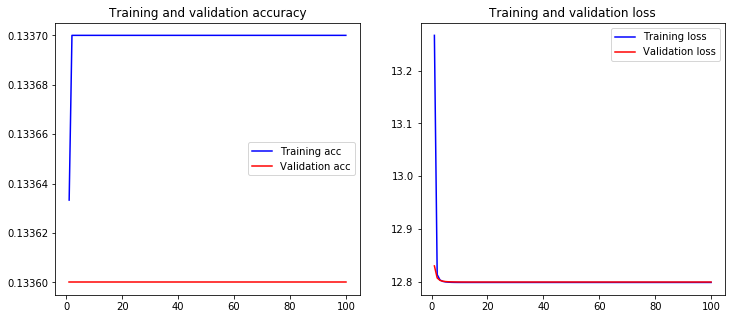

In [11]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

In [16]:
history.history['loss']

[0.4552762508392334,
 0.2358366847038269,
 0.11375173926353455,
 0.048103734850883484,
 0.019748670980334282,
 0.00926235131919384,
 0.004945398308336735,
 0.0029973206110298634,
 0.001975102350115776,
 0.0014174176612868905]